# Abalone Analysis

&nbsp;

<i><b>Specimen Growth Analytics - Using Data to Isolate Mature Samples<b><i>

<i><b>Notebook by Carl Di Martini<b>

&nbsp;

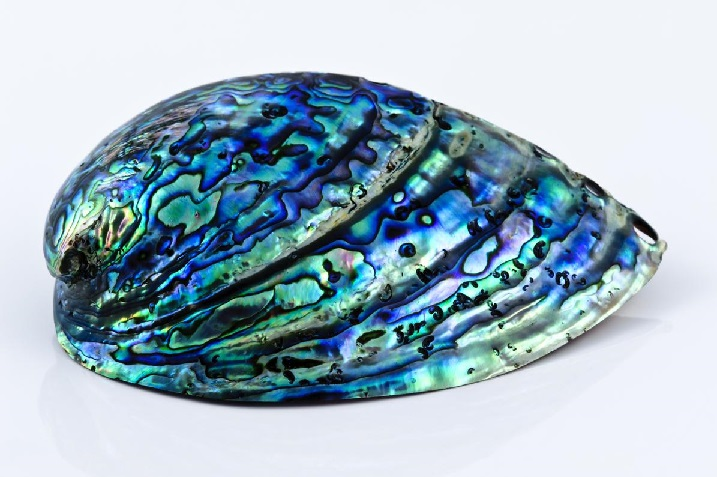

&nbsp;

According to [Wikipedia](https://en.wikipedia.org/wiki/Abalone), "Abalone is a common name for any of a group of small to very large sea snails, marine gastropod mollusks in the family Haliotidae."  To put it simply, we are taking about a shell-fish that is found in the wild and served in restaurants.  Glad that they're on the menu.  Right? 

&nbsp;

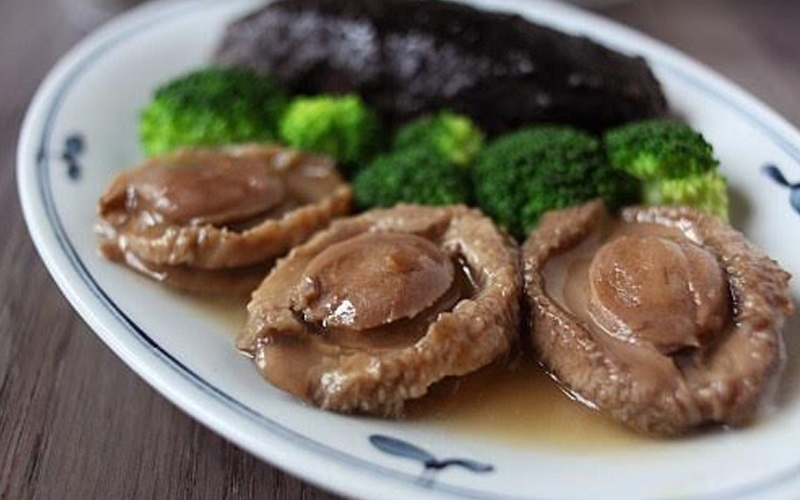

Abalone are indeed tasty but perhaps too appetizing for their own good.  This [article](https://www.ocregister.com/2016/05/29/white-abalone-were-nearly-eaten-out-of-existence-in-the-1970s-now-a-breeding-program-aims-to-revive-them/) in the Orange County Register, a California-based publication, explains the history of this mollusk as a target of over-fishing, threatened with extinction.  Sadly, they go well with broccoli.  These concerns have spurred on the Aquarium of the Pacific in Long Beach, California to breed and study these delightful creatures and enhance our understanding of how they live in the wild.

&nbsp;

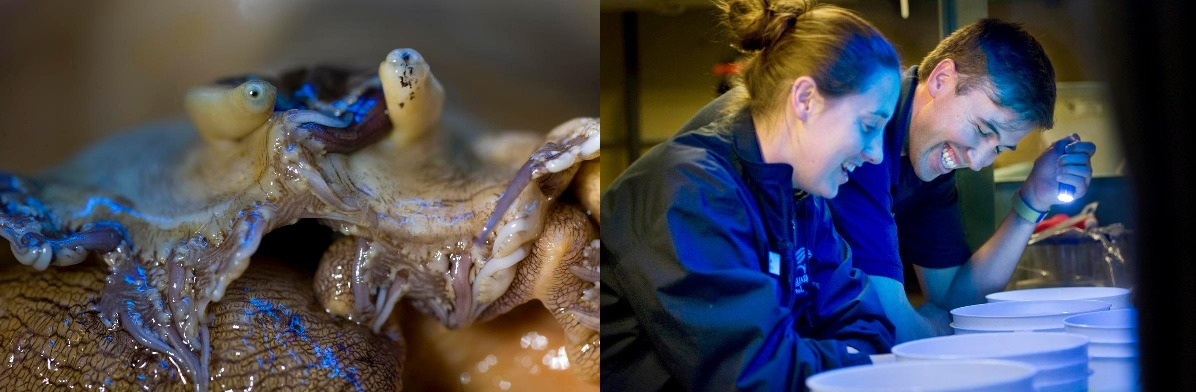

&nbsp;

### Abstract

<b>The purpose of this Jupyter Notebook</b> is not to sell you on Abalone as pets but to aid these scientific efforts by analyzing growth patterns.  Age in years is calculated by adding 1.5 to the number of growth rings according to the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/abalone).  Ring count can be determined under a microscope but can it be predicted using data?  Yes, but with difficulty.  Available data is limited to specimen measurements in millimeters and grams along with sex.  Variables affecting growth rate such as ambient conditions and specimen pedigree are not included.  Acknowledging these limitations, the goal here is to assist studies that require the isolation of mature shell fish.  This will be done by generating an effective minimum number of rings as calculated from data for samples that are at least 10 years old.

### Acknowledgements
Special thanks to the aforementioned data repository at UCI for this dataset and to the Orange County Register (linked to above) from which visuals were borrowed.

&nbsp;

   ### 1. Exploratory Data Analysis (EDA):

To escape death by Jupyter notebook, the EDA has been broken out into a separate [notebook](https://github.com/CarlDiMartini/Abalone-Capstone/blob/main/EDA.ipynb) where a usable revision of the main data frame is exported to a file to be loaded in the section below.

<br>

### 2. Ingesting packages and data:

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib import rcParams
sns.set(style="darkgrid")
plt.style.use('ggplot')
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from skopt import gp_minimize
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
import itertools

In [3]:
data = pd.read_csv('data_cleaned.csv').drop('Unnamed: 0', axis=1)

In [4]:
data.index, data.index.values.shape

(RangeIndex(start=0, stop=4171, step=1), (4171,))

In [5]:
data.head().style.hide_index()

"Sex (M, F, and neutral)",Length of Shell-mm (longest),Diameter-mm (perpendicular to longest),Height-mm (shell with meat),Whole-g (entire specimen),Shucked-g (meat),Viscera-g (gut after bleeding),Shell-g (dry),Rings Count
M,0.455000,0.365000,0.095000,0.514000,0.224500,0.101000,0.150000,15
M,0.350000,0.265000,0.090000,0.225500,0.099500,0.048500,0.070000,7
F,0.530000,0.420000,0.135000,0.677000,0.256500,0.141500,0.210000,9
M,0.440000,0.365000,0.125000,0.516000,0.215500,0.114000,0.155000,10
neutral,0.330000,0.255000,0.080000,0.205000,0.089500,0.039500,0.055000,7


The last two Python cells produce the same output as the two cells immediately preceding the data export in the other notebook.  This is the intended result.

<br>

### 3. One-Hot Coding:

In [6]:
data['Sex (M, F, and neutral)'].unique()

array(['M', 'F', 'neutral'], dtype=object)

This column with three unique values will be one-hot encoded.

In [7]:
sex_one_hot = pd.get_dummies(data['Sex (M, F, and neutral)'])

In [8]:
sex_one_hot.head()

,F,M,neutral
0,0,1,0
1,0,1,0
2,1,0,0
3,0,1,0
4,0,0,1


No need for the column, 'neutral'.  Instead allow a 0 entry in the other two gender columns to signify the absence of a sex.

In [9]:
sex_one_hot.drop('neutral', axis=1, inplace=True)
sex_one_hot.head().style.hide_index()

F,M
0,1
0,1
1,0
0,1
0,0


Substituting into the main data frame:

In [10]:
data[sex_one_hot.columns] = sex_one_hot
data.drop('Sex (M, F, and neutral)', axis=1, inplace=True)
data.head().style.hide_index()

Length of Shell-mm (longest),Diameter-mm (perpendicular to longest),Height-mm (shell with meat),Whole-g (entire specimen),Shucked-g (meat),Viscera-g (gut after bleeding),Shell-g (dry),Rings Count,F,M
0.455000,0.365000,0.095000,0.514000,0.224500,0.101000,0.150000,15,0,1
0.350000,0.265000,0.090000,0.225500,0.099500,0.048500,0.070000,7,0,1
0.530000,0.420000,0.135000,0.677000,0.256500,0.141500,0.210000,9,1,0
0.440000,0.365000,0.125000,0.516000,0.215500,0.114000,0.155000,10,0,1
0.330000,0.255000,0.080000,0.205000,0.089500,0.039500,0.055000,7,0,0


<br>

### 4. Machine Learning Input Validation:

Most of the columns in the main data frame will be treated as inputs.  The one exception is 'Rings Count', the expected output to be set aside for the time being.  This section will put to rest any doubts about these inputs even after the EDA modifications broken out in the other notebook.  Following is a series of regressions and classifications, each linking one of the data fields to the other eight where each of the nine fields gets its turn to be the dependent variable.

<br>

### 4.a. Random Forest Regression with Bayesian Optimization:

In [11]:
def input_validator(X, y):
    global y_test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    scaler_object = StandardScaler()
    scaler_object.fit(X_train)
    X_train = scaler_object.transform(X_train)
    X_test = scaler_object.transform(X_test)
    
    def objective(params):
        global y_pred
        n_estimators = params[0]
        max_features = params[1]
        min_samples_split = params[2]
        bootstrap = params[3]
        min_samples_leaf = params[4]
        max_depth = params[5]
    
        model = RandomForestRegressor\
        (\
         n_jobs=-1, random_state=0, n_estimators = n_estimators,\
         max_features = params[1],\
         min_samples_split = params[2],\
         bootstrap = params[3],\
         min_samples_leaf = params[4],\
         max_depth = params[5]\
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        return -metrics.r2_score(y_test, y_pred)
    space = [\
        [i for i in range(10,120,10)],                     #n_estimators                
        ["auto", "sqrt", "log2"],                          #max_features
        [2,4,8],                                           #min_samples_split
        [True, False],                                     #bootstrap
        [1, 2, 4],                                         #min_samples_leaf
        [i for i in range(10,120,10)]                      #max_depth
        ]
    
    return gp_minimize(objective, space, n_calls=50, random_state=0)

In [19]:
def input_formatter(column_number):
    return input_validator(data.drop(['Rings Count', data.columns[column_number]], axis=1), \
                           data[data.columns[column_number]])

In [170]:
results = []
for i in range(7):
    r = input_formatter(i)
    results = results + [r.x, -r.fun]
results

[[90, 'log2', 8, True, 1, 20],
 0.9777842180463806,
 [100, 'auto', 8, True, 4, 40],
 0.9754066380049145,
 [30, 'sqrt', 8, True, 4, 10],
 0.8684512006522145,
 [100, 'auto', 8, True, 1, 100],
 0.989244313344069,
 [110, 'auto', 4, True, 1, 70],
 0.965282787589199,
 [90, 'auto', 4, True, 2, 70],
 0.9412371272279777,
 [30, 'auto', 8, True, 2, 20],
 0.9511829638710175]

In [171]:
np.mean(np.array([np.array([results], dtype=object)[0][i] for i in range (1,12,2)], dtype=object))

0.9529010474774592

We have a mean r2 score of 95.3% for the regressions.

<br>

### 4.b. Random Forest Classification:

In [12]:
def input_validator_class(X, y):
    global y_test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    scaler_object = StandardScaler()
    scaler_object.fit(X_train)
    X_train = scaler_object.transform(X_train)
    X_test = scaler_object.transform(X_test)
    
    def objective(params):
        global y_pred, probs
        n_estimators = params[0]
        max_features = params[1]
        min_samples_split = params[2]
        bootstrap = params[3]
        min_samples_leaf = params[4]
        max_depth = params[5]
    
        model = RandomForestClassifier\
        (\
         n_jobs=-1, random_state=0, n_estimators = n_estimators,\
         max_features = params[1],\
         min_samples_split = params[2],\
         bootstrap = params[3],\
         min_samples_leaf = params[4],\
         max_depth = params[5]\
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        probs = model.predict_proba(X_test)
        return -metrics.accuracy_score(y_test, y_pred)
    space = [\
        [i for i in range(10,120,10)],                     #n_estimators                
        ["auto", "sqrt", "log2"],                          #max_features
        [2,4,8],                                           #min_samples_split
        [True, False],                                     #bootstrap
        [1, 2, 4],                                         #min_samples_leaf
        [i for i in range(10,120,10)]                      #max_depth
        ]
    
    return gp_minimize(objective, space, n_calls=50, random_state=0)

In [14]:
rF = input_validator_class(data.drop(['Rings Count', 'F'], axis=1), data['F'])
rF.x, -rF.fun

([50, 'sqrt', 2, True, 4, 70], 0.9048656499636892)

In [175]:
rM = input_validator_class(data.drop(['Rings Count', 'M'], axis=1), data['M'])
rM.x, -rM.fun

([100, 'sqrt', 8, True, 2, 40], 0.8634713144517067)

Accuracy scores of 90.5% and 86.3% are enough to connect these two fields to the other fields.  Keeping the data set intact:

<br>

### 5. Establishing Sample Maturity:

As defined by the sample being at least 10 years old.

In [13]:
data['old sample'] = data['Rings Count'] >= 10

In [14]:
r = input_validator_class(data.drop(['Rings Count', 'old sample'], axis=1), data['old sample'])
r.x, -r.fun

([90, 'auto', 8, True, 1, 30], 0.8155410312273057)

81.5% certainty is not enough.  We need a regression to establish how many rings are needed beyond 10 to boost the certainty.    Also, breaking out the present results in separate variables will allow comparisons later.

In [15]:
y_test_10, y_pred_10, prob_10 = y_test, y_pred, probs[:, 1]

<br>

### 6. Regression Analysis of Rings Count:

In [35]:
_ = input_validator(data.drop(['Rings Count', 'old sample'], axis=1), data['Rings Count'])

In [28]:
y_test.head()

404      7
3977     6
269     13
1741    11
2318    10
Name: Rings Count, dtype: int64

In [29]:
pd.Series(y_pred).head()

0     7.483409
1    10.148766
2    10.008052
3    11.658849
4     7.970584
dtype: float64

A comparison will be made between the data series in the two cells above in 'head()' form.  Simplifying to 'A' verses 'B':

In [30]:
A, B = y_test.reset_index(drop=True), pd.Series(y_pred)

In [31]:
comparison = 2*abs(A-B)/(A+B) <= 0.38
np.sum(np.array(comparison))/len(y_pred)

0.9520697167755992

This says that the calculated ring count has a 95.2% chance of being within a 38% delta of the actual case based on the absolute value of the difference divided by the average (i.e. of the calculated and actual results).  To put this in perspective, consider a collection of deltas against their respective likelihoods:

In [32]:
comparisons = [np.sum(np.array(2*abs(A-B)/(A+B) <= i))/len(y_pred) for i in np.array([i for i in range(100)])/100]

[]

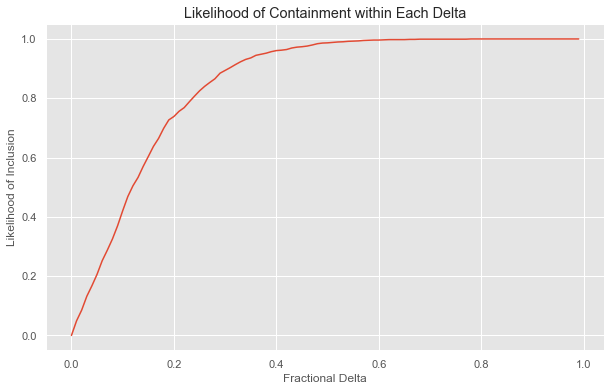

In [33]:
plt.figure(figsize = (10,6))
plt.xlabel('Fractional Delta')
plt.ylabel('Likelihood of Inclusion')
plt.title('Likelihood of Containment within Each Delta')
plt.plot(np.array([i for i in range(100)])/100, comparisons)
plt.plot()

<br>

The one-sided <b>95% confidence interval</b> explained above provides a preliminary answer for how to cull samples for being at least 10 years old.  If

2*abs(A-B)/(A+B) = 0.38,

with B=10 growth rings and A>B, the solution for A would be

A = (2 + 0.38)*B/(2 - 0.38).

In [34]:
(2 + 0.38)*10/(2 - 0.38)

14.691358024691356

The answer, which requires rounding up, is 15 rings.  Here's a check:

In [35]:
2*(14.691358024691356 - 10)/(14.691358024691356 + 10)

0.3799999999999999

<br>

### 7. Further Adjustments

This section requires comparisons that show the result of culling samples with more than 10 annual growth rings to boost the probability of each sample being at least 10 years old.

<br>

### 7.a Classification Reports

Here is the result of culling samples with only 10 predicted growth rings:  (y_test_10 and y_pred_10 were saved from the last random forest classification.)

In [37]:
print(classification_report(y_test_10, y_pred_10))

              precision    recall  f1-score   support

       False       0.82      0.74      0.78       691
        True       0.76      0.84      0.80       686

    accuracy                           0.79      1377
   macro avg       0.79      0.79      0.79      1377
weighted avg       0.79      0.79      0.79      1377



An attempt will be made to improve on this result.  Using the most recent regression, a new variable called y_test_reg, the boolean for test values greater than or equal to 10 will be classified against y_pred_15 for predicted values of 15 or higher as calculated already.

In [36]:
y_test_reg, y_pred_15 = y_test >= 10, pd.Series(y_pred) >= 15

In [122]:
print(classification_report(y_test_reg, y_pred_15))

              precision    recall  f1-score   support

       False       0.51      1.00      0.67       681
        True       1.00      0.05      0.10       696

    accuracy                           0.52      1377
   macro avg       0.75      0.53      0.39      1377
weighted avg       0.76      0.52      0.39      1377



The key comparison is for the 'precision' of the 'True' result.  In the first classification report, it was only 0.76 but after buffering it was raised to 1.00, a perfect score.  The 'recall' in the second table is only 0.05 for 'True' meaning that it will be necessary to go through a large number of observations to meet the buffered criteria.  Perhaps we can improve on this too.

In [37]:
y_pred_14 = y_pred >= 14

In [124]:
print(classification_report(y_test_reg, y_pred_14))

              precision    recall  f1-score   support

       False       0.52      1.00      0.69       681
        True       0.99      0.11      0.19       696

    accuracy                           0.55      1377
   macro avg       0.75      0.55      0.44      1377
weighted avg       0.76      0.55      0.44      1377



Here the critical precision was lowered to 99% but the corresponding recall has increased to 11%.  The recommendation is therefor to use samples with 14 growth rings or more.  Now for more side-by-side comparisons where the buffered case stipulates 14 predicted growth rings:

<br>

### 7.b. ROC Curves

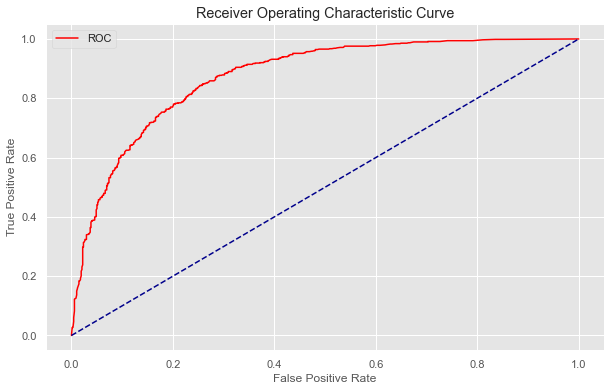

In [16]:
fpr, tpr, thresholds = roc_curve(y_test_10, prob_10)
plt.figure(figsize = (10,6))
plt.plot(fpr, tpr, color='red', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()

This ROC curve uses the Boolean series for 10 or more observed rings with the corresponding array of probabilities.  Blowing up the far left hand side of the chart (without the dotted blue line showing a meaningless 'coin flip' test):

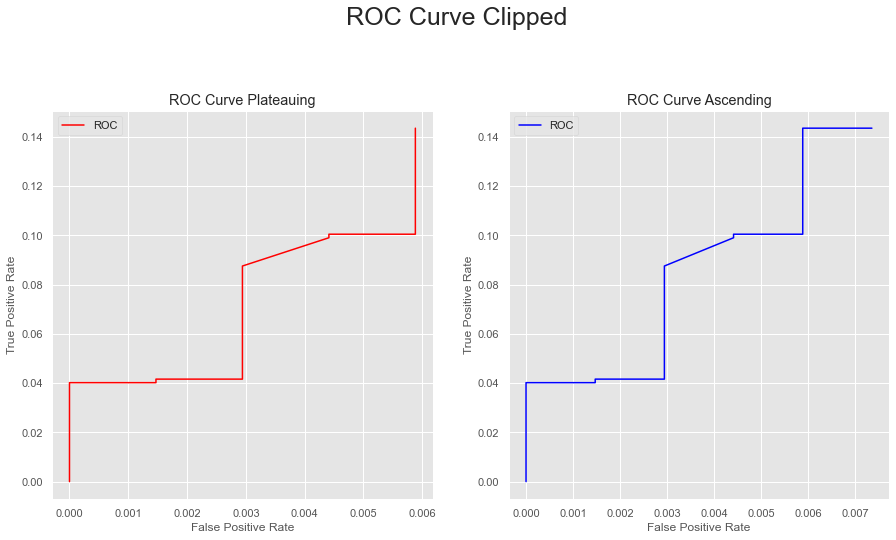

In [16]:
fig = plt.figure(figsize=(20,8))
fig.set_figwidth(15)
fig.suptitle('ROC Curve Clipped', fontsize=25)
fig.subplots_adjust(top=0.8)

plt.subplot(1,2,1)
fpr, tpr, thresholds = roc_curve(y_test_10, prob_10)
plt.plot(fpr[:18], tpr[:18], color='red', label='ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Plateauing')
plt.legend()

plt.subplot(1,2,2)
fpr, tpr, thresholds = roc_curve(y_test_10, prob_10)
plt.plot(fpr[:19], tpr[:19], color='blue', label='ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Ascending')
plt.legend()

for i in range(4):
    print()

This blow-up shows roughly the same result as the last classification matrix where the true positive rate levels off at just over 14% with almost a 1% false positive rate.  This leveling off serves as a caution to stay at fourteen projected growth rings and not go lower.  The slight difference between the information shown here and the classification matrix is from the classification regression being repeated in linear form to drill down to the region of the ROC curve highlighted presently.  Taking a local ratio of false positive results to the sum of all positives:

In [17]:
fpr[18]/(tpr[18] + fpr[18])

0.04875148632580262

It is concerning that, in this case, 4.9% of the samples are still not old enough to meet the stated requirement for sample maturity which highlights the need for more control over the conditions in which these organisms are raised along with other factors such as pedigree.

<br>

### 7.c. Confusion Matrices

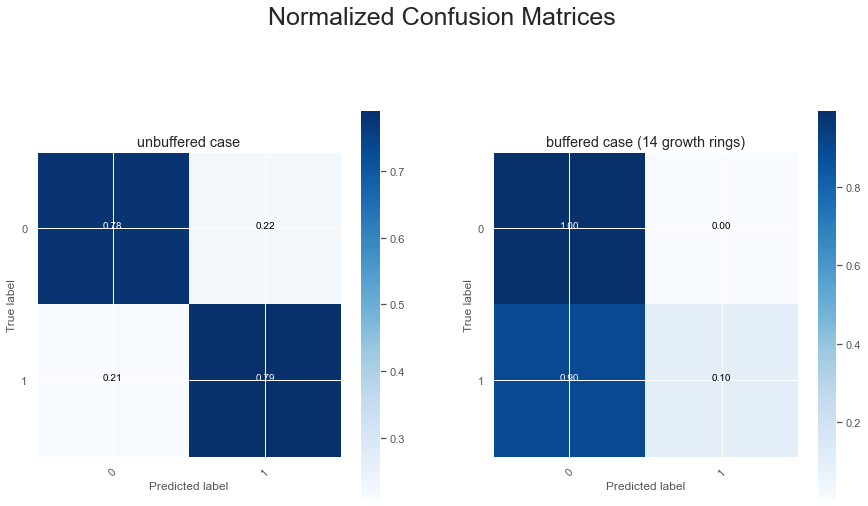

In [38]:
fig = plt.figure(figsize=(20,8))
fig.set_figwidth(15)
fig.suptitle('Normalized Confusion Matrices', fontsize=25)
fig.subplots_adjust(top=0.8)

def confusion_matrix_plotter(test_observations, predicted, pane_number, pane_title):
    plt.subplot(1,2,pane_number)
    cnf_matrix = confusion_matrix(test_observations, predicted)
    np.set_printoptions(precision=2)
    cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(pane_title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, [0, 1], rotation=45)
    plt.yticks(tick_marks, [0, 1])
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
confusion_matrix_plotter(y_test_10, y_pred_10, 1, 'unbuffered case')
confusion_matrix_plotter(y_test_reg, y_pred_14, 2, 'buffered case (14 growth rings)')

for i in range(4):
    print()

<br>

Comparing the two panes, the dark blue in the upper left hand corner area shows the advantage of buffering (i.e. better culling of samples) and the the bottom right shows the disadvantage thereof (i.e. the volume of samples that have to be considered).

<br>

### 8. Conclusions

As explained above, age of sample is interpreted as 1.5 years plus the number of annual growth rings.  To isolate mature samples defined as 10 years old or older, the obvious answer is to find samples with at least that many growth rings.  The purpose of data analysis is to avoid taking the ring count and instead extrapolate it from data.  Once this is done, added confidence can be gained by buffering the tally with additional predicted rings but not without substantial trade-offs between the degree of certainty of each sample's maturity and the volume of shellfish that have to be picked through.  In conclusion, calculations of ring count compared to actual ring count can be used to generate a numerical growth index to assess the health of populations for their capacity to grow either faster or slower than model projections.

<br>

### 9. Executive Summary

This project started with a raw data set from the UCI Machine Learning Repository and a simple objective that calls for a systematic evaluation to relate measured and categorical data to one particular numerical data field.

Exploratory data analysis was presented in a separate notebook and began with an examination of the categorical data field for specimen gender.  Every observation was reported as having one of three genders: male, female or infant.  No material changes were needed here although there was a recognition that 'infant' samples are not necessarily young samples but rather samples lacking or having a neutral a sex.  EDA was also done to trim the data set based on sanity checks.  These checks looked for strange outlier data based on simple relationships between measurements in millimeters or grams.  The data description furnished by UCI provided some guidance for this process along with basic expectations such as the requirement that a whole sample can not be heavier than its components.  Additionally, the ratios between measured values and ring counts at every life cycle phase were deemed plausible.

Later, the subject of gender was revisited to look at Pearson correlation coefficients between the ring count and various measurements for each of the three reported genders.  Randomization was done 10,000 times over to determine the p value for the observed dissimilarity between the sexes.  The conclusion is that sex in abalone shellfish is more than a social construct.  The fastest growing, most robust cases are female while the samples with no sex at all take on age with the least growth.  Males are in the middle.  The overall result was to retain sex for ring count projections.

With the data set deemed ready for implementation, one hot encoding was used to represent male and female cases with a '1' and '0' and neutral observations with a pair of 0's.  (A pair of 1's is the only impossible combination here because an abalone can not be both male and female.)  Regressions and machine learning classifications were used as a final sanity confirmation to show how each of the data fields that are input into ring count calculations relates to the other data fields used in this process.  As with all other regressions and classifications, random forests were used with Bayesian parameter tuning and a 2/3 to 1/3 training to testing split.

A classification of sample maturity (as defined above) was done based on all the other data fields as modified.  This classification was found to be prone to false positives to be reduced by padding with additional rings in the projection.  A preliminary answer was obtained by buffering for a one-sided 95% confidence interval as the most pessimistic likelihood for any given specimen.  From a classification matrix, the trade-off due to the large number of samples having to be culled advised the removal of one ring from the buffer.  The ROC curve and its associated calculations along with the confusion matrix further shed light on these trade-offs and the limitations on the insight to be gained from the available data.  Buffering was examined with the help of regressions.

A follow-on project would work these comparisons of calculated and actual ring counts into an index for quantifying the overall health of samples based on how rapidly they grow.